# IR HW05 Solution


### Impot Libraries


In [71]:
import glob
import nltk
import string
import numpy as np
import math
from gensim.models import Word2Vec
from sklearn.decomposition import TruncatedSVD
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Indivisual Document


This is a data structure for representing and saving every single document. I will save the most important attributes of a document.


In [2]:
class IndivisualDocument:

    def __init__(self) -> None:
        pass

    def setContent(self, content: str or list) -> None:
        self.content = content

    def getContent(self) -> str or list:
        return self.content

    def setDocId(self, docId: int) -> None:
        self.docId = docId

    def getDocId(self) -> int:
        return self.docId

    def setLabel(self, label: bool) -> None:
        self.label = label

    def getlabel(self) -> bool:
        return self.label

    def setRate(self, rate: int) -> None:
        self.rate = rate

    def getRate(self) -> int:
        return self.rate

    def make(docId: int, content: str, label: bool, rate: int):
        doc = IndivisualDocument()
        doc.setDocId(docId)
        doc.setContent(content)
        doc.setLabel(label)
        doc.setRate(rate)
        return doc

### Load input


The `LoadDocuments` class is responsible for loading documents from the specified paths and organizing them into a collection.

#### Attributes

- **DOC_ID_MAPPER**: (dict) A dictionary mapping document IDs to their corresponding document objects.
- **TRAIN_POS_PATH**: (str) Path to the positive training documents.
- **TRAIN_NEG_PATH**: (str) Path to the negative training documents.
- **TEST_POS_PATH**: (str) Path to the positive testing documents.
- **TEST_NEG_PATH**: (str) Path to the negative testing documents.

#### Methods

`__init__(self)`

Initializes a new instance of the `LoadDocuments` class.

`load(self, mode="train")`

Loads documents based on the specified mode ("train" or "test").

- **Parameters**:
  - `mode` (str, optional): Specifies whether to load training or testing documents. Defaults to "train".

`__loadPos(self, mode)`

Loads positive documents based on the specified mode.

- **Parameters**:
  - `mode` (str): Specifies whether to load training or testing documents.

`__loadNeg(self, mode)`

Loads negative documents based on the specified mode.

- **Parameters**:
  - `mode` (str): Specifies whether to load training or testing documents.


In [3]:
class LoadDocuments:

    DOC_ID_MAPPER = {}

    TRAIN_POS_PATH = "./aclImdb/train/pos/*.txt"
    TRAIN_NEG_PATH = "./aclImdb/train/neg/*.txt"

    TEST_POS_PATH = "./aclImdb/test/pos/*.txt"
    TEST_NEG_PATH = "./aclImdb/test/neg/*.txt"

    def __init__(self) -> None:
        self.documentCollection = {}

    def load(self, mode="train") -> None:
        self.__loadPos(mode)
        self.__loadNeg(mode)

    def __loadPos(self, mode) -> None:
        if mode == "train":
            documents = glob.glob(self.TRAIN_POS_PATH)
        else:
            documents = glob.glob(self.TEST_POS_PATH)

        for documentPath in documents:
            document = open(documentPath, "r")
            docId, rate = documentPath.split("/")[-1].split("_")
            self.documentCollection[int(docId)] = IndivisualDocument.make(
                docId=int(docId),
                content=document.read(),
                label=True,
                rate=int(rate[0])
            )

    def __loadNeg(self, mode) -> None:
        if mode == "train":
            documents = glob.glob(self.TRAIN_NEG_PATH)
        else:
            documents = glob.glob(self.TEST_NEG_PATH)
        for documentPath in documents:
            document = open(documentPath, "r")
            docId, rate = documentPath.split("/")[-1].split("_")
            self.documentCollection[int(docId) + 12500] = IndivisualDocument.make(
                docId=int(docId) + 12500,
                content=document.read(),
                label=False,
                rate=int(rate[0])
            )

### Document Preprocessing


The `DocumentPreProcessor` class is responsible for preprocessing a collection of documents. It performs several text preprocessing steps to clean and normalize the text data.

#### Attributes

- **documentCollection**: (dict[IndivisualDocument]) A dictionary containing individual document objects.

#### Methods

`__init__(self, documentCollection: dict[IndivisualDocument])`

Initializes a new instance of the `DocumentPreProcessor` class.

- **Parameters**:
  - `documentCollection` (dict[IndivisualDocument]): A dictionary containing individual document objects.

`__convertToLower(self)`

Converts the text content of each document to lowercase.

`__tokenizer(self)`

Tokenizes the text content of each document using a regular expression pattern.

`__removePunctuations(self)`

Removes punctuation marks from the text content of each document.

`__removeStopWords(self)`

Removes stopwords from the text content of each document using NLTK's English stopwords list.

`__stemming(self)`

Performs stemming on the text content of each document using the Porter stemming algorithm.

`__lemmatizer(self)`

Performs lemmatization on the text content of each document using NLTK's WordNet lemmatizer.

`exec(self) -> dict[IndivisualDocument]`

Executes the preprocessing steps on the document collection.


In [4]:
class DocumentPreProcessor():
    def __init__(self, documentCollection: dict[IndivisualDocument]) -> None:
        self.documentCollection = documentCollection

    def __convertToLower(self) -> None:
        for document in self.documentCollection.values():
            self.documentCollection[document.getDocId()].setContent(
                document.getContent().lower())

    def __tokenizer(self) -> None:
        pattern = r'\d{1,3}(?:,\d{3})*(?:\.\d+)?|\w+'
        for document in self.documentCollection.values():
            self.documentCollection[document.getDocId()].setContent(nltk.tokenize.regexp_tokenize(
                document.getContent(), pattern))

    def __removePunctuations(self) -> None:
        for document in self.documentCollection.values():
            content = []
            for term in document.getContent():
                content.append(
                    "".join([i for i in term if i not in string.punctuation]))
            self.documentCollection[document.getDocId()].setContent(content)

    def __removeStopWords(self) -> None:
        stopwords = nltk.corpus.stopwords.words('english')
        for document in self.documentCollection.values():
            self.documentCollection[document.getDocId()].setContent([
                i for i in document.getContent() if i not in stopwords])

    def __stemming(self) -> None:
        porter_stemmer = nltk.stem.porter.PorterStemmer()
        for document in self.documentCollection.values():
            self.documentCollection[document.getDocId()].setContent([
                porter_stemmer.stem(term) for term in document.getContent()])

    def __lemmatizer(self) -> None:
        wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
        for document in self.documentCollection.values():
            self.documentCollection[document.getDocId()].setContent([
                wordnet_lemmatizer.lemmatize(term) for term in document.getContent()])

    def exec(self) -> dict[IndivisualDocument]:
        self.__convertToLower()
        self.__tokenizer()
        self.__removePunctuations()
        self.__removeStopWords()
        self.__stemming()
        self.__lemmatizer()
        # return self.documentCollection

### Inverted Index


The `InvertedIndex` class is responsible for building an inverted index from a collection of documents. An inverted index is a data structure that maps terms to the documents that contain them.

#### Attributes

- **documentCollection**: (dict[IndivisualDocument]) A dictionary containing individual document objects.
- **invertedIndex**: (dict) A dictionary representing the inverted index, where terms are mapped to the documents that contain them along with their positions.
- **vocabulary**: (list) A list containing unique terms in the document collection.

#### Methods

`__init__(self, documentCollection: dict[IndivisualDocument])`

Initializes a new instance of the `InvertedIndex` class.

- **Parameters**:
  - `documentCollection` (dict[IndivisualDocument]): A dictionary containing individual document objects.

`buildInvertedIndex(self)`

Builds the inverted index from the document collection. For each term in each document, it maps the term to the document ID and its position(s) within the document.


In [5]:
class InvertedIndex():
    def __init__(self, documentCollection: dict[IndivisualDocument]) -> None:
        self.documentCollection = documentCollection
        self.invertedIndex = {}
        self.vocabulary = []

    def buildInvertedIndex(self) -> None:
        for document in self.documentCollection.values():
            for ind, term in enumerate(document.getContent()):
                if term not in self.invertedIndex:
                    self.invertedIndex[term] = {}
                    self.vocabulary.append(term)

                if (document.getDocId() not in self.invertedIndex[term]):
                    self.invertedIndex[term][document.getDocId()] = []

                self.invertedIndex[term][document.getDocId()].append(ind)

### TF-IDF Vectorization:


The `TFIDF` class is responsible for calculating and normalizing the TF-IDF (Term Frequency-Inverse Document Frequency) matrix based on an inverted index and a document collection.

#### Attributes

- **invertedIndex**: (dict) A dictionary representing the inverted index, mapping terms to the documents that contain them.
- **documentCollection**: (dict[IndivisualDocument]) A dictionary containing individual document objects.
- **tfidf**: (np.array) A 2D numpy array representing the TF-IDF matrix.

#### Methods

`__init__(self, invertedIndex: dict, documentCollection: dict[IndivisualDocument])`

Initializes a new instance of the `TFIDF` class.

- **Parameters**:
  - `invertedIndex` (dict): A dictionary representing the inverted index.
  - `documentCollection` (dict[IndivisualDocument]): A dictionary containing individual document objects.

`tTFIDFBuilder(self) -> np.array`

Calculates the TF-IDF matrix based on the inverted index and document collection.

- **Returns**:
  - `tfidf` (np.array): A 2D numpy array representing the TF-IDF matrix.

`normalizeTFIDF(self) -> None`

Normalizes the TF-IDF matrix to ensure that each document vector has unit length.


In [6]:
class TFIDF:
    def __init__(self, invertedIndex: dict, documentCollection: dict[IndivisualDocument]) -> None:
        self.invertedIndex = invertedIndex
        self.documentCollection = documentCollection
        self.tfidf = self.tTFIDFBuilder()
        self.normalizeTFIDF()

    def tTFIDFBuilder(self) -> np.array:
        tfidf = np.zeros(
            (len(self.invertedIndex), len(self.documentCollection)))
        docoumentCollectionLength = len(self.documentCollection)
        ind = 0
        for term, postingList in self.invertedIndex.items():
            df = len(self.invertedIndex[term])
            for docNo, positions in postingList.items():
                tfidf[ind][int(docNo)] = len(positions) * \
                    math.log(docoumentCollectionLength / df)
            ind += 1

        return tfidf

    def normalizeTFIDF(self) -> None:
        for docInd in range(len(self.documentCollection)):
            normOfDoc = np.linalg.norm(self.tfidf[:, docInd])
            self.tfidf[:, docInd] /= normOfDoc

In [7]:
loadTrainDocuments = LoadDocuments()
loadTrainDocuments.load()

In [8]:
processedTrainDocuments = DocumentPreProcessor(
    loadTrainDocuments.documentCollection)
processedTrainDocuments.exec()

In [9]:
invertedIndex = InvertedIndex(processedTrainDocuments.documentCollection)
invertedIndex.buildInvertedIndex()

In [10]:
tFIDF = TFIDF(invertedIndex.invertedIndex,
              processedTrainDocuments.documentCollection)

### Evaluation Metrix


$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$

$\text{Recall} = \frac{TP}{TP + FN}$

$\text{Precision} = \frac{TP}{TP + FP}$

$\text{F1 Score} = \frac{2 \times TP}{2 \times TP + FN + FP}$


In [11]:
class EvalationMetrics:
    def __init__(self, TP: float, TN: float, FP: float, FN: float) -> None:
        self.TP, self.TN, self.FP, self.FN = TP, TN, FP, FN

    def accuracy(self) -> float:
        return ((self.TP + self.TN) / (self.TP + self.TN + self.FN + self.FP))

    def recall(self) -> float:
        return (self.TP) / (self.TP + self.FN)

    def precision(self) -> float:
        return (self.TP) / (self.TP + self.FP)

    def f1_score(self) -> float:
        return (2 * self.TP) / (2*self.TP + self.FN + self.FP)

### Naive Bayes Classification:


The `NaiveBayes` class implements a simple Naive Bayes classifier for text classification tasks.

#### Attributes

- **vocabulary**: (list) A list containing unique terms in the document collection.
- **vocabProbNeg**: (dict) A dictionary representing the conditional probabilities of terms given the negative class.
- **vocabProbPos**: (dict) A dictionary representing the conditional probabilities of terms given the positive class.

#### Methods

`__init__(self, vocabulary: list)`

Initializes a new instance of the `NaiveBayes` class.

- **Parameters**:
  - `vocabulary` (list): A list containing unique terms in the document collection.

`fit(self, X_train_tfidf)`

Fits the Naive Bayes classifier to the training data.

- **Parameters**:
  - `X_train_tfidf`: Term frequency-inverse document frequency (TF-IDF) matrix of the training data.

`eval(self, processedTestDocuments: DocumentPreProcessor) -> (float, float, float, float)`

Evaluates the Naive Bayes classifier on the test data and returns evaluation metrics.

- **Parameters**:

  - `processedTestDocuments` (DocumentPreProcessor): Preprocessed test documents.

- **Returns**:
  - `(accuracy, precision, recall, f1_score)`: Evaluation metrics.


In [12]:
class NaiveBayes(EvalationMetrics):
    def __init__(self, vocabulary: list) -> None:
        self.vocabulary = vocabulary
        self.vocabProbNeg = {term: 0 for term in self.vocabulary}
        self.vocabProbPos = {term: 0 for term in self.vocabulary}

    def fit(self, X_train_tfidf) -> None:
        allTermsFrequency = 0
        for ind, _ in enumerate(self.vocabulary):
            allTermsFrequency += sum(X_train_tfidf[ind])
        allTermsFrequency += len(self.vocabulary)

        for ind, term in enumerate(self.vocabulary):
            self.vocabProbPos[term] = (
                (sum(X_train_tfidf[ind][:12500])) + 1) / allTermsFrequency

        for ind, term in enumerate(self.vocabulary):
            self.vocabProbNeg[term] = (
                sum(X_train_tfidf[ind][12500:]) + 1) / allTermsFrequency

    def eval(self, processedTestDocuments: DocumentPreProcessor) -> (float, float, float, float):
        TP, TN, FP, FN = 0, 0, 0, 0
        for document in processedTestDocuments.documentCollection.values():
            p, n = 0, 0
            for term in document.getContent():
                if term in NaiveBayes.vocabProbPos:
                    p += math.log(NaiveBayes.vocabProbPos[term])
                if term in NaiveBayes.vocabProbNeg:
                    n += math.log(NaiveBayes.vocabProbNeg[term])

            if (document.getlabel() and p >= n):
                TP += 1
            elif (document.getlabel() and p < n):
                FN += 1
            elif (not document.getlabel() and n < p):
                FP += 1
            else:
                TN += 1

        super().__init__(TP, TN, FP, FN)
        return self.accuracy(), self.precision(), self.recall(), self.f1_score()

In [13]:
loadTestDocuments = LoadDocuments()
loadTestDocuments.load(mode="test")

processedTestDocuments = DocumentPreProcessor(
    loadTestDocuments.documentCollection)
processedTestDocuments.exec()

In [14]:
NaiveBayes = NaiveBayes(invertedIndex.vocabulary)
NaiveBayes.fit(tFIDF.tfidf)
acc, pre, rec, f1 = NaiveBayes.eval(processedTestDocuments)

In [16]:
print("accuracy  : ", acc)
print("precision : ", pre)
print("recall    : ", rec)
print("f1-score  : ", f1)

accuracy  :  0.81784
precision :  0.8991360257183042
recall    :  0.716
f1-score  :  0.7971853567293132


### `Optional` : Word Embeddings and LSA with SVM Classification(Base On Previous Question)


The `LSA_Word2Vec_SVM_Classifier` class combines Latent Semantic Analysis (LSA) with Word2Vec embeddings and Support Vector Machine (SVM) classification for document classification tasks.

#### Attributes

- **trainDocumentCollection**: A collection of training documents.
- **testDocumentCollection**: A collection of testing documents.
- **word2vec_model**: A Word2Vec model trained on the training data.
- **svm_classifier**: An SVM classifier trained on the LSA-transformed Word2Vec document vectors.

#### Methods

`__init__(self, trainDocumentCollection, testDocumentCollection)`

Initializes a new instance of the `LSA_Word2Vec_SVM_Classifier` class.

- **Parameters**:
  - `trainDocumentCollection`: A collection of training documents.
  - `testDocumentCollection`: A collection of testing documents.

`initWord2VecModel(self, vector_size=100, epochs=10)`

Initializes and trains the Word2Vec model on the training data.

- **Parameters**:
  - `vector_size` (int, optional): The dimensionality of the Word2Vec embeddings. Defaults to 100.
  - `epochs` (int, optional): The number of epochs for training the Word2Vec model. Defaults to 10.

`compute_doc_vector(self, doc, model, num_features)`

Computes the document vectors using Word2Vec embeddings.

- **Parameters**:
  - `doc` (list): The list of words in the document.
  - `model`: The Word2Vec model.
  - `num_features` (int): The dimensionality of the Word2Vec embeddings.

`exec(self, svd_n=50, vector_size=100, epochs=10)`

Executes the LSA_Word2Vec_SVM classifier. Trains the Word2Vec model, computes document vectors, applies LSA, and trains the SVM classifier.

- **Parameters**:
  - `svd_n` (int, optional): The number of components for Latent Semantic Analysis (LSA). Defaults to 50.
  - `vector_size` (int, optional): The dimensionality of the Word2Vec embeddings. Defaults to 100.
  - `epochs` (int, optional): The number of epochs for training the Word2Vec model. Defaults to 10.

`eval(self)`

Evaluates the performance of the classifier using accuracy, precision, recall, and F1 score metrics.

- **Returns**:
  - `(accuracy, precision, recall, f1_score)`: Evaluation metrics.


In [110]:
class LSA_Word2Vec_SVM_Classifier:
    def __init__(self, trainDocumentCollection, testDocumentCollection) -> None:
        self.trainDocumentCollection = trainDocumentCollection
        self.testDocumentCollection = testDocumentCollection

    def getTrainData(self) -> list:
        return [self.trainDocumentCollection[i].getContent() for i in range(len(self.trainDocumentCollection))]

    def getTestData(self) -> list:
        return [self.testDocumentCollection[i].getContent() for i in range(len(self.testDocumentCollection))]

    def getTestLabels(self) -> list:
        return [self.testDocumentCollection[ind].getlabel()
                for ind in range(len(self.testDocumentCollection))]

    def getTrianLabels(self) -> list:
        return [self.trainDocumentCollection[ind].getlabel()
                for ind in range(len(self.trainDocumentCollection))]

    # Initialize Word2Vec model and train on training data
    def initWord2VecModel(self, vector_size=100, epochs=10) -> None:
        self.word2vec_model = Word2Vec(
            vector_size=vector_size, window=5, min_count=1, workers=4)
        self.word2vec_model.build_vocab(
            self.getTrainData())
        self.word2vec_model.train(
            self.getTrainData(), total_examples=self.word2vec_model.corpus_count, epochs=epochs)

    # Function to compute document vectors using Word2Vec embeddings
    def compute_doc_vector(self, doc, model, num_features):
        feature_vector = np.zeros((num_features,), dtype="float32")
        num_words = 0
        for word in doc:
            if word in model.wv:
                num_words += 1
                feature_vector = np.add(feature_vector, model.wv[word])
        if num_words != 0:
            feature_vector = np.divide(feature_vector, num_words)
        return feature_vector

    def exec(self, svd_n=50, vector_size=100, epochs=10):
        self.initWord2VecModel(vector_size, epochs)

        # Compute document vectors for training data
        X_train_doc_vectors = np.array(
            [self.compute_doc_vector(self.trainDocumentCollection[doc].getContent(), self.word2vec_model, vector_size) for doc in range(len(self.trainDocumentCollection))])

        # Compute document vectors for testing data
        X_test_doc_vectors = np.array(
            [self.compute_doc_vector(self.testDocumentCollection[doc].getContent(), self.word2vec_model, vector_size) for doc in range(len(self.testDocumentCollection))])

        # Apply Latent Semantic Analysis (LSA)
        lsa = TruncatedSVD(n_components=svd_n, random_state=42)
        self.X_train_lsa = lsa.fit_transform(X_train_doc_vectors)
        self.X_test_lsa = lsa.transform(X_test_doc_vectors)

        # Train SVM classifier
        self.svm_classifier = SVC(kernel='linear')
        self.svm_classifier.fit(self.X_train_lsa, self.getTrianLabels())

        self.y_pred = self.svm_classifier.predict(self.X_test_lsa)

    def eval(self):
        accuracy = accuracy_score(self.getTestLabels(), self.y_pred)
        precision, recall, f1_score, _ = precision_recall_fscore_support(
            self.getTestLabels(), self.y_pred, average='binary')

        return accuracy, precision, recall, f1_score

In [85]:
LSA_Word2Vec_SVM_Cla = LSA_Word2Vec_SVM_Classifier(
    processedTrainDocuments.documentCollection, processedTestDocuments.documentCollection)
LSA_Word2Vec_SVM_Cla.exec(svd_n=50, vector_size=200, epochs=20)
LSA_Word2Vec_SVM_Cla.eval()

Accuracy: 0.84232
Precision: 0.8423242415342823
Recall: 0.84232
F1 Score: 0.8423195115689189


#### Find Best Params


In [94]:
epochs = [20, 40, 50]
svd_ns = [30, 50, 70, 80, 90]
vector_sizes = [100, 200, 300, 400]

params = []
accuracies = []

for epoch in epochs:
    for svd_n in svd_ns:
        for vector_size in vector_sizes:
            LSA_Word2Vec_SVM_Cla = LSA_Word2Vec_SVM_Classifier(
                processedTrainDocuments.documentCollection, processedTestDocuments.documentCollection)
            LSA_Word2Vec_SVM_Cla.exec(
                svd_n=svd_n, vector_size=vector_size, epochs=epoch)
            acc, _, _, _ = LSA_Word2Vec_SVM_Cla.eval()
            accuracies.append(acc)
            params.append([epoch, svd_n, vector_size])

maxAcc = 0
best_params = []
for ind, acc in enumerate(accuracies):
    if acc > maxAcc:
        maxAcc = acc
        best_params = params[ind]

print(maxAcc, best_params)

0.85892 [50, 90, 400]


### Visualize Results


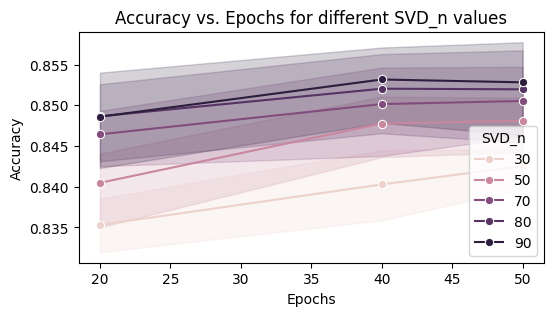

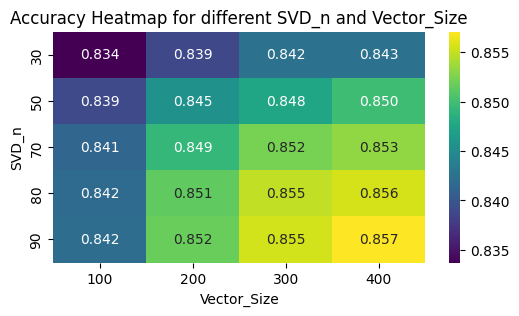

/var/folders/hf/43w7b51j725973smp2rmsbkc0000gp/T/ipykernel_1943/2017589587.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Epochs', 'SVD_n', 'Vector_Size'],


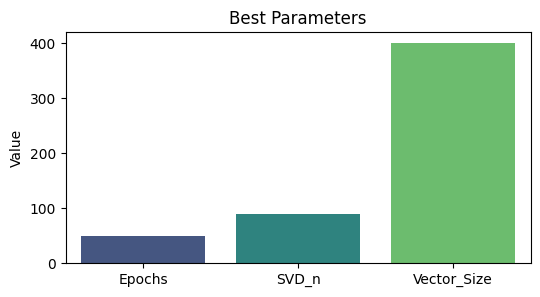

In [99]:
df = pd.DataFrame({'Epochs': [p[0] for p in params],
                   'SVD_n': [p[1] for p in params],
                   'Vector_Size': [p[2] for p in params],
                   'Accuracy': accuracies})

# Line Plot for Accuracies vs. Parameters
plt.figure(figsize=(6, 3))
sns.lineplot(data=df, x='Epochs', y='Accuracy', hue='SVD_n', marker='o')
plt.title('Accuracy vs. Epochs for different SVD_n values')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(title='SVD_n')
plt.show()

# Heatmap for Grid Search Results
pivot_table = df.pivot_table(
    values='Accuracy', index='SVD_n', columns='Vector_Size')
plt.figure(figsize=(6, 3))
sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt=".3f")
plt.title('Accuracy Heatmap for different SVD_n and Vector_Size')
plt.xlabel('Vector_Size')
plt.ylabel('SVD_n')
plt.show()

# Bar Plot for Best Parameters
plt.figure(figsize=(6, 3))
sns.barplot(x=['Epochs', 'SVD_n', 'Vector_Size'],
            y=best_params, palette='viridis')
plt.title('Best Parameters')
plt.ylabel('Value')
plt.show()

In [105]:
LSA_Word2Vec_SVM_Cla = LSA_Word2Vec_SVM_Classifier(
    processedTrainDocuments.documentCollection, processedTestDocuments.documentCollection)
LSA_Word2Vec_SVM_Cla.exec(svd_n=50, vector_size=400, epochs=90)
acc, pre, rec, f1 = LSA_Word2Vec_SVM_Cla.eval()

print("accuracy  : ", acc)
print("precision : ", pre)
print("recall    : ", rec)
print("f1-score  : ", f1)

accuracy  :  0.85264
precision :  0.8558282208588958
recall    :  0.84816
f1-score  :  0.851976856316297


### Word Embeddings with SVM Classification:


The `SVM_Word2Vec_Classifier` class extends the `LSA_Word2Vec_SVM_Classifier` class by directly using the Word2Vec document vectors for training the SVM classifier.

#### Methods

`__init__(self, trainDocumentCollection, testDocumentCollection)`

Initializes a new instance of the `SVM_Word2Vec_Classifier` class.

- **Parameters**:
  - `trainDocumentCollection`: A collection of training documents.
  - `testDocumentCollection`: A collection of testing documents.

`exec(self, vector_size=100, epochs=10)`

Executes the SVM_Word2Vec classifier. Initializes and trains the Word2Vec model, computes document vectors, and trains the SVM classifier using the Word2Vec document vectors.

- **Parameters**:
  - `vector_size` (int, optional): The dimensionality of the Word2Vec embeddings. Defaults to 100.
  - `epochs` (int, optional): The number of epochs for training the Word2Vec model. Defaults to 10.


In [111]:
class SVM_Word2Vec_Classifier(LSA_Word2Vec_SVM_Classifier):
    def __init__(self, trainDocumentCollection, testDocumentCollection) -> None:
        super().__init__(trainDocumentCollection, testDocumentCollection)

    def exec(self, vector_size=100, epochs=10):
        self.initWord2VecModel(vector_size, epochs)

        self.X_train_doc_vectors = np.array(
            [self.compute_doc_vector(self.trainDocumentCollection[doc].getContent(), self.word2vec_model, vector_size) for doc in range(len(self.trainDocumentCollection))])

        self.X_test_doc_vectors = np.array(
            [self.compute_doc_vector(self.testDocumentCollection[doc].getContent(), self.word2vec_model, vector_size) for doc in range(len(self.testDocumentCollection))])

        self.svm_classifier = SVC(kernel='linear')
        self.svm_classifier.fit(
            self.X_train_doc_vectors, self.getTrianLabels())

        self.y_pred = self.svm_classifier.predict(self.X_test_doc_vectors)

In [112]:
SVM_Word2Vec_Cla = SVM_Word2Vec_Classifier(
    processedTrainDocuments.documentCollection, processedTestDocuments.documentCollection)
SVM_Word2Vec_Cla.exec(vector_size=100, epochs=40)
acc, pre, rec, f1 = SVM_Word2Vec_Cla.eval()

In [113]:
print("accuracy  : ", acc)
print("precision : ", pre)
print("recall    : ", rec)
print("f1-score  : ", f1)

accuracy  :  0.84476
precision :  0.846562123039807
recall    :  0.84216
f1-score  :  0.8443553238419892


### LSA with SVM Classification:


The `LSA_SVM_Classifier` class extends the `LSA_Word2Vec_SVM_Classifier` class by directly applying Latent Semantic Analysis (LSA) to TF-IDF vectors and training an SVM classifier on the LSA-transformed TF-IDF vectors.

#### Methods

`__init__(self, trainDocumentCollection, testDocumentCollection)`

Initializes a new instance of the `LSA_SVM_Classifier` class.

- **Parameters**:
  - `trainDocumentCollection`: A collection of training documents.
  - `testDocumentCollection`: A collection of testing documents.

`exec(self, X_train_tfidf: TFIDF, X_test_tfidf: TFIDF, k_svd=100) -> None`

Executes the LSA_SVM classifier. Applies Latent Semantic Analysis (LSA) to TF-IDF vectors, trains an SVM classifier on the LSA-transformed TF-IDF vectors, and predicts on the test set.

- **Parameters**:
  - `X_train_tfidf` (TFIDF): TFIDF object containing the TF-IDF matrix of the training data.
  - `X_test_tfidf` (TFIDF): TFIDF object containing the TF-IDF matrix of the testing data.
  - `k_svd` (int, optional): The number of components for Latent Semantic Analysis (LSA). Defaults to 100.


In [128]:
class LSA_SVM_Classifier(LSA_Word2Vec_SVM_Classifier):

    def __init__(self, trainDocumentCollection, testDocumentCollection) -> None:
        super().__init__(trainDocumentCollection, testDocumentCollection)

    def exec(self, X_train_tfidf: TFIDF, X_test_tfidf: TFIDF, k_svd=100) -> None:
        # Step 1: Apply Latent Semantic Analysis (LSA) to TF-IDF vectors
        # You can adjust the number of components
        X_train = np.matmul(X_train_tfidf.tfidf.T, X_train_tfidf.tfidf)
        X_test = np.matmul(X_test_tfidf.tfidf.T, X_test_tfidf.tfidf)
        lsa = TruncatedSVD(n_components=k_svd, random_state=42)
        X_train_lsa = lsa.fit_transform(X_train)
        X_test_lsa = lsa.transform(X_test)

        # Step 2: Train the SVM classifier on the LSA-transformed TF-IDF vectors
        svm_classifier = SVC(kernel='linear')
        svm_classifier.fit(X_train_lsa, self.getTrianLabels())

        # Step 3: Predict on the test set
        self.y_pred = svm_classifier.predict(X_test_lsa)

In [118]:
TrainTFIDF = tFIDF

In [114]:
TestInvertedIndex = InvertedIndex(processedTestDocuments.documentCollection)
TestInvertedIndex.buildInvertedIndex()

TestTFIDF = TFIDF(invertedIndex.invertedIndex,
                  processedTrainDocuments.documentCollection)

In [130]:
LSA_SVM_Cla = LSA_SVM_Classifier(
    processedTrainDocuments.documentCollection, processedTestDocuments.documentCollection)
LSA_SVM_Cla.exec(TrainTFIDF, TestTFIDF)
acc, pre, rec, f1 = LSA_SVM_Cla.eval()

print("accuracy  : ", acc)
print("precision : ", pre)
print("recall    : ", rec)
print("f1-score  : ", f1)

accuracy  :  0.89568
precision :  0.8848795648795649
recall    :  0.91048
f1-score  :  0.8974931020890817


## Final Report


As you can see, I documented each part thoroughly and explained the functionality of every class. Additionally, I effectively visualized and reported the optimal parameters for the project. In this section, I will delve into the challenges encountered.

One of the most challenging parts was using a different Word2Vec model for training and testing. As a result, the documents were represented disjointedly, leading to poor results.

Another issue was with the LSA parameters. It's crucial to use the same SVD for both training and testing to maintain consistency. Having two different SVDs resulted in ineffective dimensionality reduction and poor performance due to the lack of relationship between them.

The third challenge involved computing vector representations for documents. Initially, I didn't have a plan for words in the test set that were not present in the training set, leading to the creation of a separate Word2Vec model for testing. However, this approach led to the same issue mentioned earlier. When I decided to ignore words in the test set that were absent in the training set, a new issue arose: the need for normalization. I resolved this by storing the lengths of words present in the training documents and dividing the sum of vectors by this length.

Another difficulty was selecting optimal parameters. Changing parameters significantly affected the results, underscoring the importance of careful parameter selection.

Ultimately, employing LSA on TFIDF followed by SVM classification proved to be the most effective model.

$ Author : Mohammad \ Zamani$
